## Hyper-parameter tuning with Bayesian optimization or how I carved boats from wood ##
https://towardsdatascience.com/bayesian-optimization-or-how-i-carved-boats-from-wood-examples-and-code-78b9c79b31e5

## Theory ##
When explaining the problem I find it useful to bear in mind the final goal. The goal of this article would be finding hyper-parameters for a deep neural network that would maximize the validation accuracy. For this we will be using bayesian optimization. We can split the process into several steps:

- Initialize the network with values of the hyper-parameters;
- Train the model and save the best accuracy on the validation set;
- Fit a Gaussian Process (GP) over the performance data collected so far. Here, the values of the hyper-parameters tested so far are independent variables and accuracies of the model with these hyper-parameter values are predictor variable;
- Use acquisition function on the GP fit to obtain the next set of hyper-parameter values with which the model is expected to attain better performance;
- Go to step 1.

Thus the process requires two important steps

- Loss function estimation — that will be achieved with Gaussian Processes;
- Acquisition function— highest expected improvement in the loss.

In [9]:
import numpy as np
import pandas as pd
import random
import math
import os
import imageio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

##from bayesian_opt import BO

import scipy.stats as scs
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

## Gaussian Processes ##
Unlike linear models, for which we select a function with a finite number of parameters, Gaussian Processes (GPs) are non-linear models and do not restrict us to one function. GPs allow for modelling the data with a family of functions.

While working with GPs, we assume that every data point is a normally distributed random variable and that every data point is related to every other. That is, the whole dataset can be described by a multi-variate normal distribution with a non-trivial covariance.

GPs are fully described by the mean m and kernell K functions. The mean function is very straightforward — it takes in the data-point features and returns the mean of the predictor variable for that datapoint. The kernel function takes as input two data points and returns the covariance between them. The kernel, describes the relationship between the datapoints and is thus an implicit constraint on the way the resultant fit would look like.

Let’s start with a simple example consisting of five data points. In our case let’s assume that the y-axis is the loss function of the machine learning algorithm we want to maximize and the x-axis is a hyper-parameter, such as burn-in preiod, that impacts the prediction accuracy.

For our Gaussian process we assume that the loss is smooth with respect to the burn-in period— we would not expect the loss to experience an abrupt change in the value after a small change in the burn-in period. Thus we choose a very standard squared exponential kernel to enforce this smoothness prior.

The choice of kernel is an art, and there is a lot of research on how to do this automatically, how to combine kernels together and how to chose the kernel for multi-dimensional data, as assumptions made for one dimension might not hold for another. More kernel visualizations can be found here. A whole branch of research is looking into learning kernels at model training time.

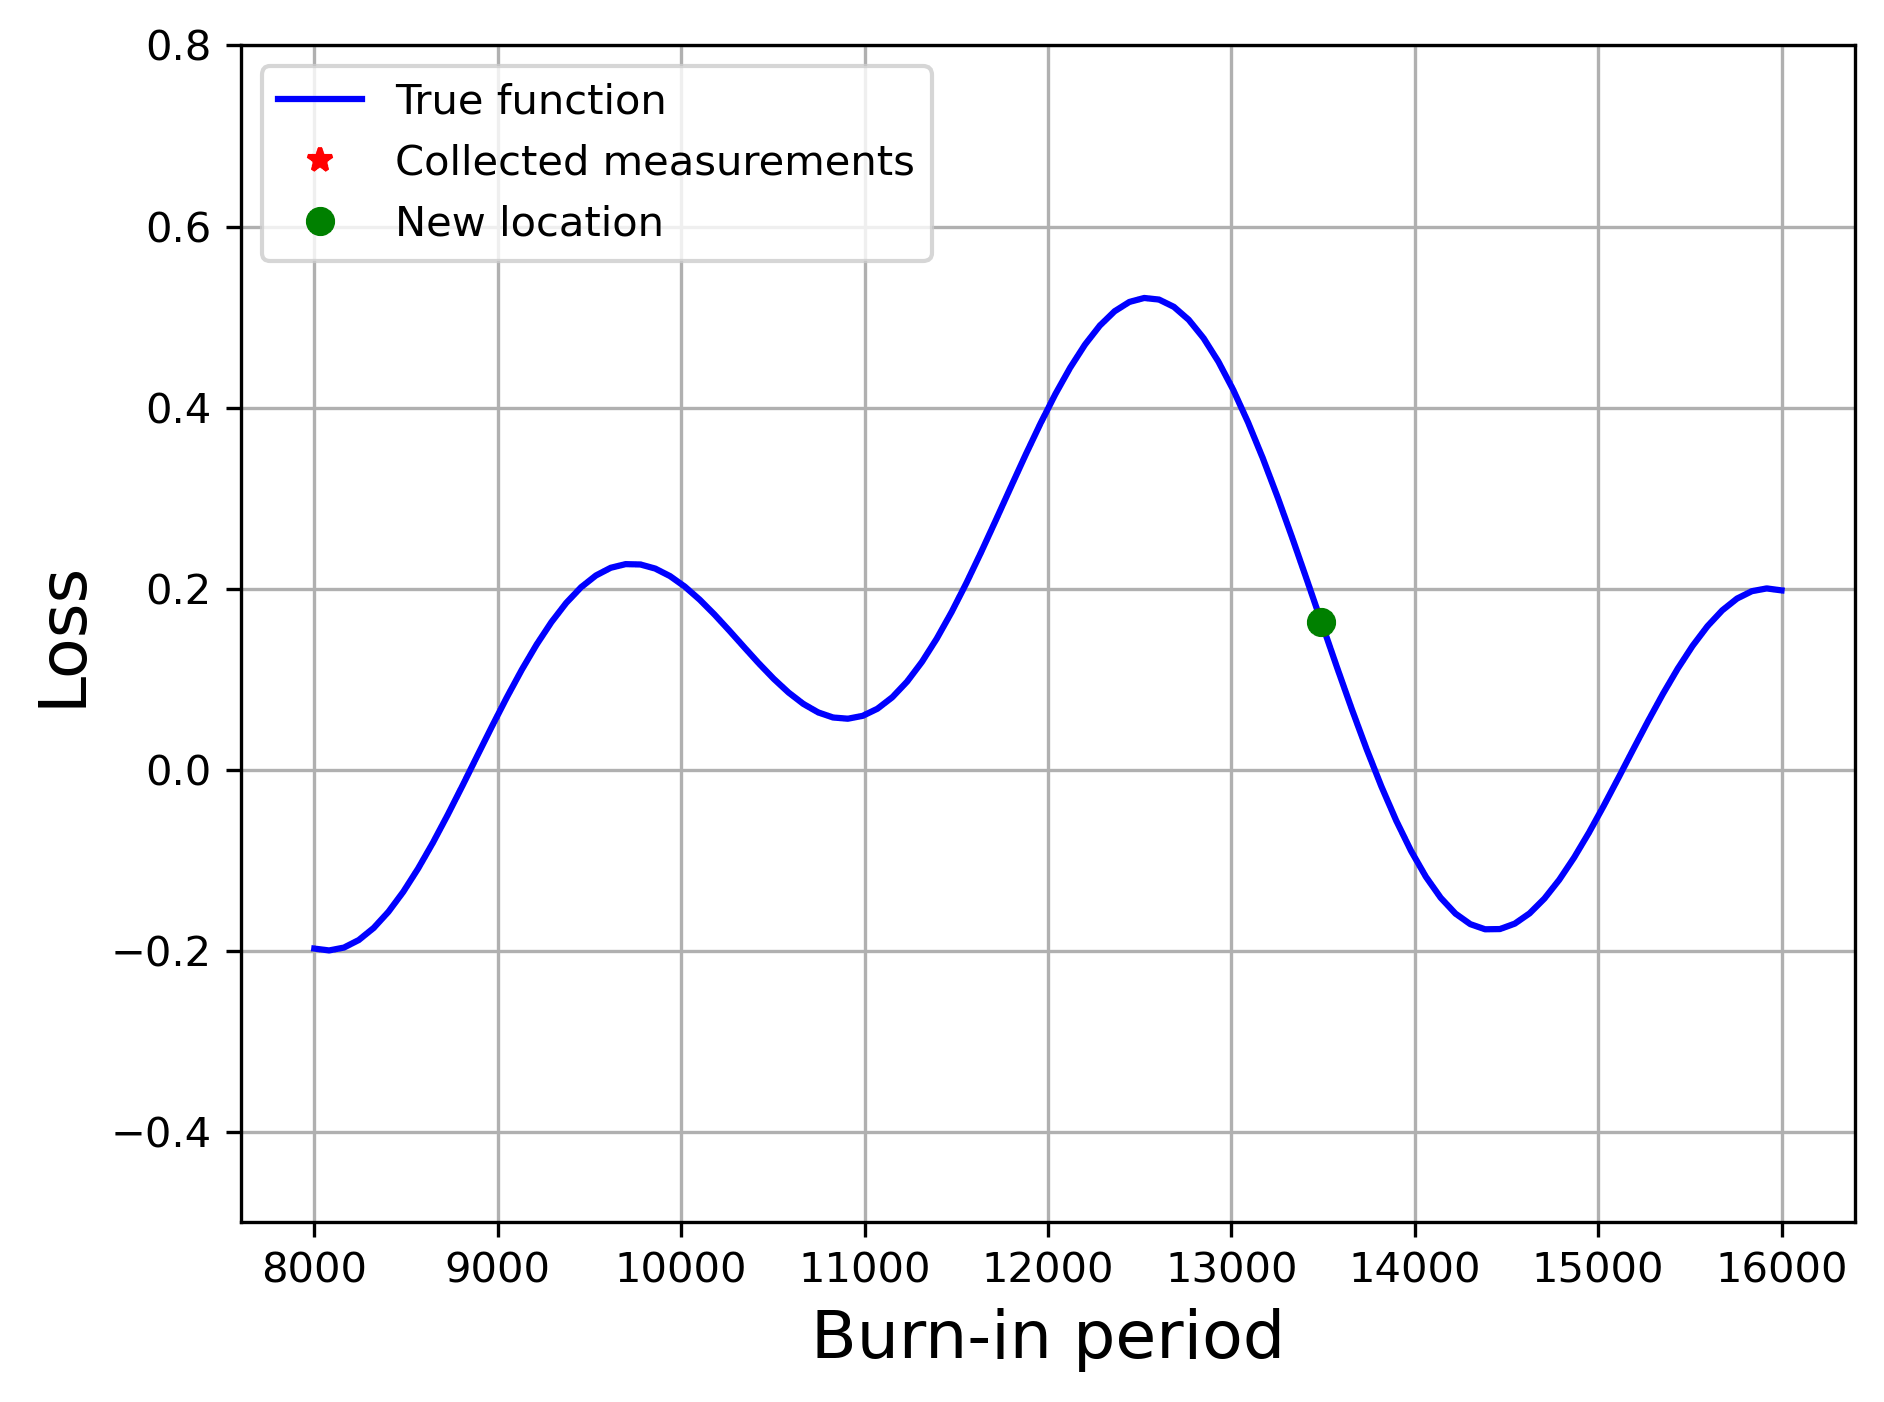

## Bayesian optimization — acquisition function##

The task in this step is to find the value of the hyper-parameter that would improve the current maximum (minimum) of the loss function for which we found a fit. To identify the potential (e.g. with respect to the expected improvement or probability of improvement) of each point to be the maximum (minimum) we use an acquisition function. The acquisition function takes in the obtained GP fit (mean and variance at each point) and returns the hyper-parameter value for the next run of the machine learning algorithm. Below we consider two simple acquisition functions: probability of improvement and expected improvement.

- Probability of improvement:
$$
\begin{aligned}
\mathrm{PI}(\mathbf{x}) & =P\left(f(\mathbf{x}) \geq \mu^{+}+\xi\right) \\
& =\Phi\left(\frac{\mu(\mathbf{x})-\mu^{+}-\xi}{\sigma(\mathbf{x})}\right)
\end{aligned}

- Expected improvement:
$$
\begin{aligned}
\mathrm{EI}(\mathbf{x}) & = \begin{cases}\left(\mu(\mathbf{x})-\mu^{+}-\xi\right) \Phi(Z)+\sigma(\mathbf{x}) \phi(Z) & \text { if } \sigma(\mathbf{x})>0 \\
0 & \text { if } \sigma(\mathbf{x})=0\end{cases} \\
Z & =\frac{\mu(\mathbf{x})-\mu^{+}-\xi}{\sigma(\mathbf{x})}
\end{aligned}
$$

In [53]:
"""
    The script for BayesOptimization
"""


class BO:
    
    def __init__(self, search_space, list_of_parameters_names, maximize):

        self.dict_of_means = {}
        self.list_of_parameters_names = list_of_parameters_names
        self.search_space = search_space
        for key in list_of_parameters_names:

            self.dict_of_means[key] = [float(search_space[key][0][1]+search_space[key][0][0])/2.0,
                                       float(search_space[key][0][1]-search_space[key][0][0])/2.0]
    
    
        # Instantiate a Gaussian Process model for Surrogate function
        self.kernel =  RBF(5, (1e-2, 1e2))*C(1, (1e-2, 1e2))+ WhiteKernel(noise_level=0.2)
    
        self.maximize = maximize
        
        self.generate_meshes()
        
        self.parameters_and_loss_dict = {}
        for item in self.list_of_parameters_names:
            self.parameters_and_loss_dict[item] = []
        self.parameters_and_loss_dict['loss'] = []
        
    def generate_meshes(self):
        
        # Create the list of ranges for the search space (start, end, number_of_points)
        list_of_ranges = []
        list_of_shapes = []
        list_of_ranges_true =[]

        search_space_normalized = {}
        for key in self.list_of_parameters_names:

            search_space_normalized[key] = [(self.search_space[key][0][0]-self.dict_of_means[key][0])/self.dict_of_means[key][1],
                                       (self.search_space[key][0][1]-self.dict_of_means[key][0])/self.dict_of_means[key][1],
                                       (self.search_space[key][0][2])]
            #print(search_space_normalized)
            list_of_ranges_true.append (np.linspace(*self.search_space[key][0]))
            list_of_ranges.append(np.linspace(*search_space_normalized[key]))
            list_of_shapes.append(self.search_space[key][0][2])

        # Create a meshgrid from the list of ranges for the searchspace
        meshgrid_linspace = np.meshgrid(*(list_of_ranges),indexing='ij')

        reshape_param = np.product(np.shape(meshgrid_linspace[0]))
        meshgrid_linspacer = []
        
        for mlinsp in meshgrid_linspace:
            meshgrid_linspacer.append(np.reshape(mlinsp,reshape_param))

        # meshgrid for GP prediction
        self.meshgrid_linspacer_stack = np.stack(meshgrid_linspacer,axis=1)
        self.list_of_shapes = list_of_shapes
        self.list_of_ranges_true = list_of_ranges_true
        self.list_of_ranges = list_of_ranges
        return 
    
    
    def normalize_current_values(self):
        normalized_param= []
        # Create a list of estimation parameters, iterate over all, skip the loss from the list
        list_of_parameters = []
        for key in self.list_of_parameters_names:
            normalized_param=[(float(param)-self.dict_of_means[key][0])/self.dict_of_means[key][1] for param in self.parameters_and_loss_dict[key]]

            list_of_parameters.append(np.atleast_2d(normalized_param).T)

        list_of_parameters_stack = np.stack(list_of_parameters,axis=1)
        

        return list_of_parameters_stack, list_of_parameters
        
        
        
    def bayes_opt(self):

        if len(self.parameters_and_loss_dict[self.list_of_parameters_names[0]])>0:
            
            # fit the model with previouse paratmers values + loss value
            # loss_evaluated include those so far evaluated loss from hyperparameters. 
            # loss_predicted include new proposal/test hyperparameters generated loss prediction
            # Generate function prediction from the parameters and the loss (run bayesian regression on surrogate function)
            loss_predicted,sigma,loss_evaluated = self.generate_prediction()

            # Calculate expected improvement (finding the maximum of the information gain function)
            expected_improvement = self.calculate_expected_improvement(loss_predicted, sigma, loss_evaluated)
            
            # Find the parameter values for the maximum values of the information gain function
            # the hyperparamters selected based on ths core that from acquisition/selection function
            next_parameter_values = self.find_next_parameter_values(expected_improvement)
            
            print("Next try paramters is {}:".format(next_parameter_values))

        else:

            next_parameter_values = {}
            for name in self.list_of_parameters_names:
                next_parameter_values[name] = self.search_space[name][1](self.search_space[name][0][0]+(self.search_space[name][0][1]-self.search_space[name][0][0])*np.random.uniform(0,1))

            loss_predicted = None
            sigma=None
            loss_evaluated=None
            expected_improvement=None   


        parameters_and_loss_df=pd.DataFrame.from_dict(self.parameters_and_loss_dict,orient='index').transpose()   
        
        # Write the results into the dataframe
        list_of_next_values = []

        for item in self.list_of_parameters_names:
            # Add all parameters to the list, so that they can be appended to the dataframe
            # While iterating convert to the preffered datatype
            list_of_next_values.append(self.search_space[item][1](round(next_parameter_values[item],5)))
            next_parameter_values[item] = (self.search_space[item][1](round(next_parameter_values[item],5)))

        # Check that the output is not repeated (can happen as we are using white noize kernel) in this case generate point at random
        while (parameters_and_loss_df[self.list_of_parameters_names]== list_of_next_values).all(1).any():
            list_of_next_values = []
            for item in self.list_of_parameters_names:
                rand_value = self.search_space[item][1](round(random.uniform(self.search_space[item][0][0], self.search_space[item][0][1]),5))
                next_parameter_values[item] = rand_value
                list_of_next_values.append(rand_value)


        for item in self.list_of_parameters_names:
            self.parameters_and_loss_dict[item].append(next_parameter_values[item])
        
        
        return next_parameter_values, loss_predicted, sigma, expected_improvement


    def update_loss(self, value):
        
        self.parameters_and_loss_dict['loss'].append(value)
        
        return
    
    # define the gaussian module as surrogate function 
    def fit_gp(self, list_of_parameters_stack, list_of_parameters,loss_evaluated):

        gp = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=200)

        # update the model with the (paramters value , loss value )
        # Fit to data using Maximum Likelihood Estimation of the parameters
        gp.fit(np.reshape(list_of_parameters_stack,(-1,len(list_of_parameters))), loss_evaluated)
    
        # Make the prediction on the meshed x-axis (ask for MSE as well)
        loss_predicted, sigma = gp.predict(self.meshgrid_linspacer_stack, return_std=True)

        loss_predicted = np.reshape(loss_predicted,self.list_of_shapes)
        sigma = np.reshape(sigma,self.list_of_shapes)

        return loss_predicted, sigma 

    #the prediction/loss based on the surrogate function 
    def generate_prediction(self):

        list_of_parameters_stack, list_of_parameters = self.normalize_current_values()
        # use the ture loss function loss as y, the input is the generated next hyperparameters value
        loss_evaluated = self.parameters_and_loss_dict['loss']
        #normalize the loss_evaluated
        if len(self.parameters_and_loss_dict['loss'])>1:
            loss_evaluated = (self.parameters_and_loss_dict['loss']-np.mean(self.parameters_and_loss_dict['loss']))/(np.std(self.parameters_and_loss_dict['loss'])+1e-6)

        #feed the surrogate model with the value(list_of_parameters_stack, loss_evaluated) include the new added loss value
        loss_predicted, sigma  = self.fit_gp(list_of_parameters_stack, list_of_parameters, loss_evaluated)

        return loss_predicted,sigma,loss_evaluated


    def calculate_expected_improvement(self, loss_predicted, sigma, loss_evaluated):

        # Calculate the expected improvement
        eps = 1e-6
        num =(loss_predicted-max(loss_evaluated)-eps)
        Z=num/sigma
        expected_improvement = num*scs.norm(0,1).cdf(Z)+sigma*scs.norm(0,1).pdf(Z)
        expected_improvement[sigma==0.0] = 0.0

        return expected_improvement

    #get propsal parameter from the index -- maximum value from expected_improvement
    def find_next_parameter_values(self, expected_improvement):
        
        
        if self.maximize:
            index = np.where(expected_improvement==np.amax(expected_improvement))
        else:
            index = np.where(expected_improvement==np.amin(expected_improvement))

        next_parameter_values = {}
        # Iterate over all parameter values and find those corresponding to maximum EI
        for idx, parameter in enumerate(self.list_of_parameters_names):

            # Since more than one value can be have max at EI,select one at random
            x = int(np.random.uniform(0,len(index[idx])))
            next_parameter_values[parameter] = self.list_of_ranges_true[idx][index[idx][x]]

        return next_parameter_values





**following function seems define as the true loss function for the hyper-parameters, but acctually in practise we don't know this or it is not easy to optimize**  
**per my understanding it could be replaced  with the loss calucation from true prediction and ground truth**

In [11]:
def one_dim_function_simple(burnin):
    '''
    Maximum is attained at 12000
    '''
    f = -((burnin-12000)/10000)**2
    return f

def one_dim_function_complex(burnin):
    '''
    Maximum is attained at 12000
    '''
    f = norm.pdf((burnin-12000)/1000)+np.sin((burnin-12000)/500)/5
    return f


def two_dim_function_simple(burnin, learning_rate):
    '''
    Maximum is attained at 12000, 1.5
    '''
    f = (-((burnin-12000)/10000)**2)+(-(learning_rate-1.25)**2)
    return f


def two_dim_function_complex(burnin, learning_rate):
    '''
    Maximum is attained at 12000, 1.5
    '''
    
    x = (burnin-12000)/1000
    y = (learning_rate-1)*2-1.5
    
    f = (1-(x**2+y**3))*np.exp(-(x**2+y**2)/2)

    return f

In [12]:
def generate_images_1D(path_to_images,data,loss_predicted,sigma,search_space,iteration):
    if not os.path.isdir(path_to_images):
        os.mkdir(path_to_images)

    mean_loss = data['loss'].mean()
    std_loss = data['loss'].std()
    # Plot and save the fit
    x = np.linspace(*search_space['burnin_period'][0])    
    plt.figure()
    plt.plot(x, one_dim_function_complex(x),'b',label="True function");
    plt.plot(data['burnin_period'].values,data['loss'].values,'*r',label="Collected measurements")
    plt.plot(data['burnin_period'].values[-1],data['loss'].values[-1],'og',label="New location")
        
    if ii>0:
        if ii>1:
            loss_predicted= loss_predicted*std_loss+mean_loss
            sigma= sigma*std_loss+mean_loss        

        plt.plot(x,loss_predicted,'r',label="Predicted function")
        plt.fill_between(x, loss_predicted - sigma,
                 loss_predicted + sigma,
                 alpha=0.5, color='c',label="Standard deviation")  
    plt.ylim([-.5, .8])
    plt.grid()
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Burn-in period', fontsize=16)
    plt.tight_layout()
    plt.legend(loc = 'upper left')
    plt.savefig(path_to_images+str(iteration)+'.png', bbox_inches='tight',dpi=300)
    

def generate_images_2D(path_to_images,data,loss_predicted,sigma,search_space,iteration):
    if not os.path.isdir(path_to_images):
        os.mkdir(path_to_images)
        
    
    mean_loss = data['loss'].mean()
    std_loss = data['loss'].std()
    
    # Plot the data
    fig = plt.figure()
    ax = fig.add_subplot(1,2,1, projection='3d')
    # Make data.
    burnin_period =  np.linspace(*search_space['burnin_period'][0])
    learning_rate =  np.linspace(*search_space['learning_rate'][0]) 
    X, Y = np.meshgrid(burnin_period, learning_rate,indexing='ij')

    Z = two_dim_function_complex(X, Y)

    # Customize the z axis.
    ax.set_zlim(-.5, 1.5)
    ax.set_ylim(search_space['learning_rate'][0][0], search_space['learning_rate'][0][1])
    ax.set_xlim(search_space['burnin_period'][0][0], search_space['burnin_period'][0][1])
    ax.set_xlabel('Burn-in period')
    ax.set_ylabel('Learning rate')
    ax.set_zlabel('Loss')

    ax.scatter(data['burnin_period'].values, data['learning_rate'].values, data['loss'].values, color='b', linewidth=0.5);
    ax.scatter(data['burnin_period'].values[-1], data['learning_rate'].values[-1], data['loss'].values[-1], color='r', linewidth=0.5);

        
    if ii>0:
        if ii>1:
            loss_predicted= loss_predicted*(std_loss+1e-6)+mean_loss        
        
        surf_2 = ax.plot_surface(X,Y, loss_predicted, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        
    
    ax = fig.add_subplot(1,2,2)
    if ii>0:
        #fig = plt.figure()
        
        ax.contour(X,Y,loss_predicted)
        ax.contourf(X,Y,loss_predicted, cmap='viridis')
        ax.plot(data['burnin_period'].values, data['learning_rate'].values, 'ko')
        
        ax.plot(data['burnin_period'].values[-1], data['learning_rate'].values[-1], 'ro')
        ax.set_xlabel('Burn-in period')
        ax.set_ylabel('Learning rate')
    else:
        ax.contourf(X,Y,np.zeros((np.shape(X))), cmap='viridis')
        
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    fig.tight_layout(pad=6.0)
    fig.savefig(path_to_images+str(iteration)+'.png', bbox_inches='tight',dpi=300)



    
def generate_gif(path_to_images,number_of_iterations):
    # Write out images to a gif
    images = []
    for ii in range(0,number_of_iterations):
        filename = path_to_images+str(ii)+'.png'
        image = imageio.imread(filename)
        images.append(image)
    imageio.mimsave((path_to_images+'movie.gif'), images, duration = 1) # modify duration as needed


# 1D Example

When explaining the problem I find it useful to bear in mind the final goal. The goal of this article would be finding hyper-parameters for a deep neural network that would maximize the validation accuracy. For this we will be using bayesian optimization. We can split the process into several steps:

- Initialize the network with values of the hyper-parameters;
- Train the model and save the best accuracy on the validation set;
- Fit a Gaussian Process (GP) over the performance data collected so far. <font color=red> Here, the values of the hyper-parameters tested so far are independent variables and accuracies of the model with these hyper-parameter values are predictor variable </font>;
- Use acquisition function on the GP fit to obtain the next set of hyper-parameter values with which the model is expected to attain better performance;
- Go to step 1.

Iteration:  0
The loss is:0.163056
Iteration:  1


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 14303.030303030304}:
The loss is:-0.170737
Iteration:  2


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 13414.141414141413}:
The loss is:0.208503
Iteration:  3


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 12929.29292929293}:
The loss is:0.450929
Iteration:  4


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 12444.444444444445}:
The loss is:0.516657
Iteration:  5


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 8000.0}:
The loss is:-0.197738
Iteration:  6


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 10101.0101010101}:
The loss is:0.187796
Iteration:  7


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 16000.0}:
The loss is:0.198005
Iteration:  8


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 12525.252525252525}:
The loss is:0.521068
Iteration:  9


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 12525.252525252525}:
The loss is:-0.087977
Iteration:  10


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 12525.252525252525}:
The loss is:0.399342
Iteration:  11


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 12525.252525252525}:
The loss is:0.140696
Iteration:  12


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 12525.252525252525}:
The loss is:0.064279
Iteration:  13


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 12525.252525252525}:
The loss is:0.112892
Iteration:  14


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 12525.252525252525}:
The loss is:0.438441


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


    burnin_period      loss
0         13491.0  0.163056
1         14303.0 -0.170737
2         13414.0  0.208503
3         12929.0  0.450929
4         12444.0  0.516657
5          8000.0 -0.197738
6         10101.0  0.187796
7         16000.0  0.198005
8         12525.0  0.521068
9         14897.0 -0.087977
10        12001.0  0.399342
11        11382.0  0.140696
12         9010.0  0.064279
13        11292.0  0.112892
14        12105.0  0.438441


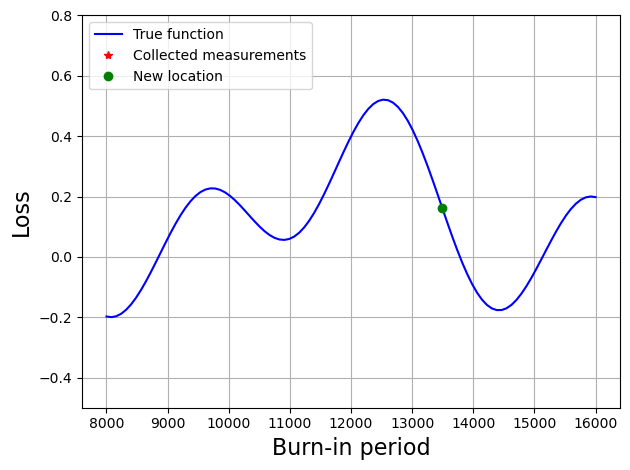

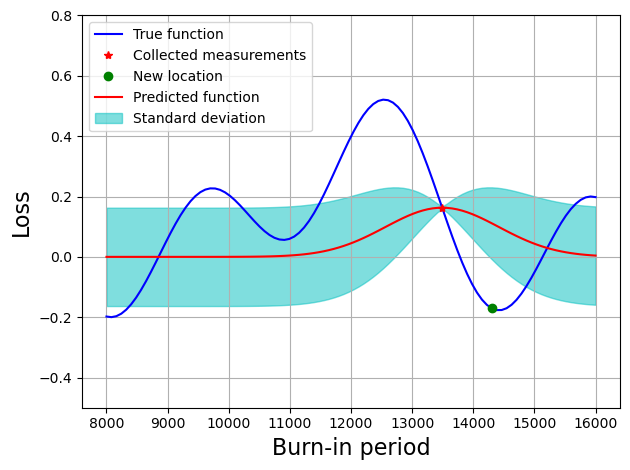

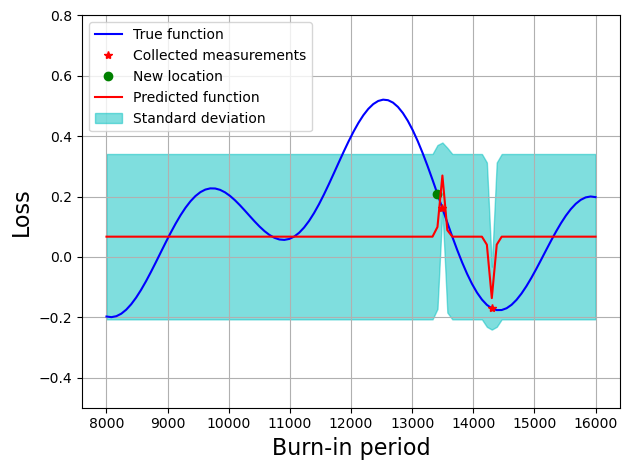

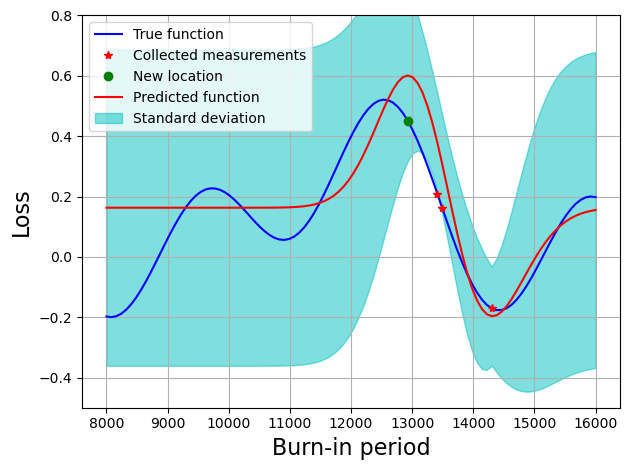

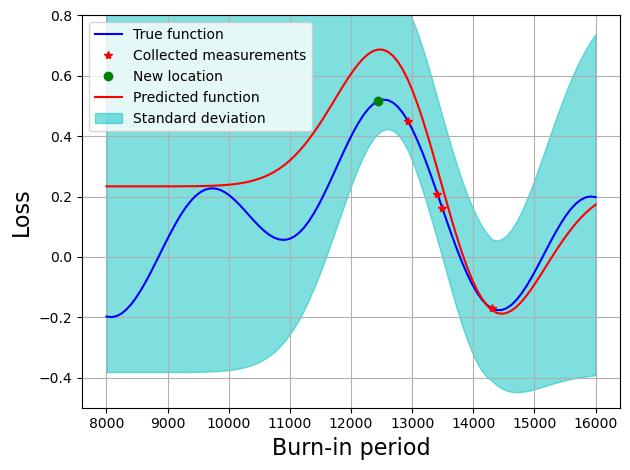

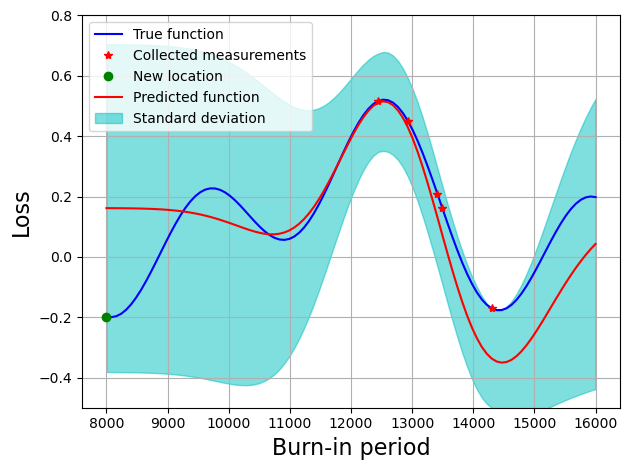

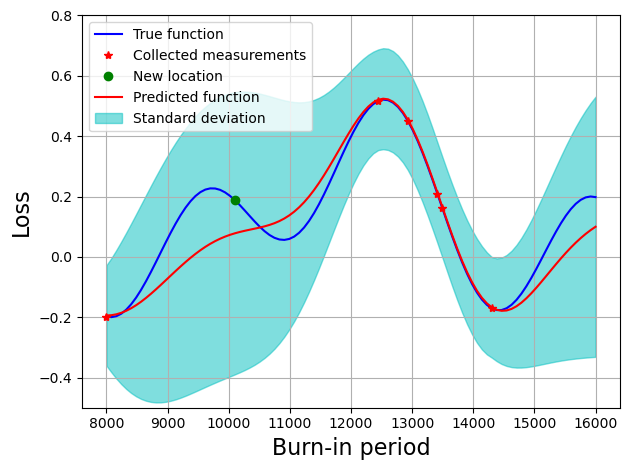

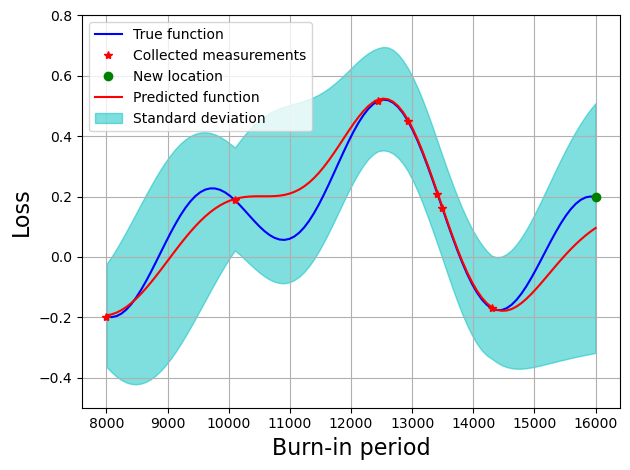

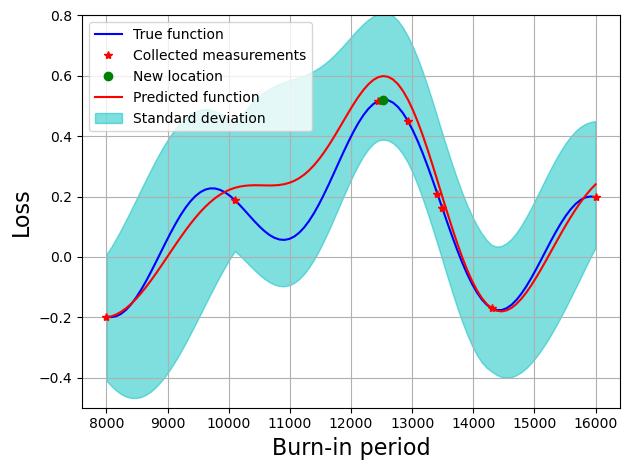

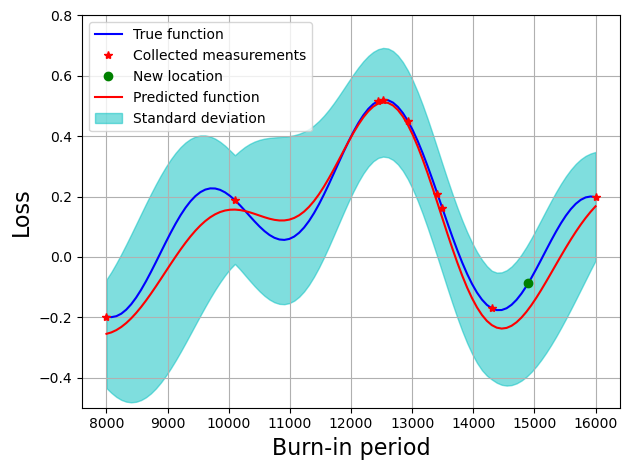

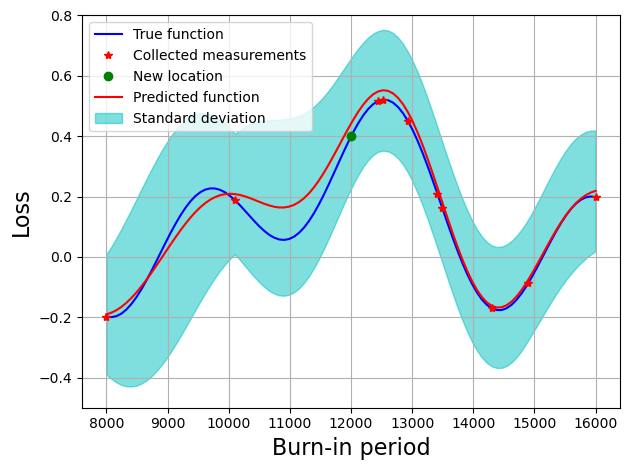

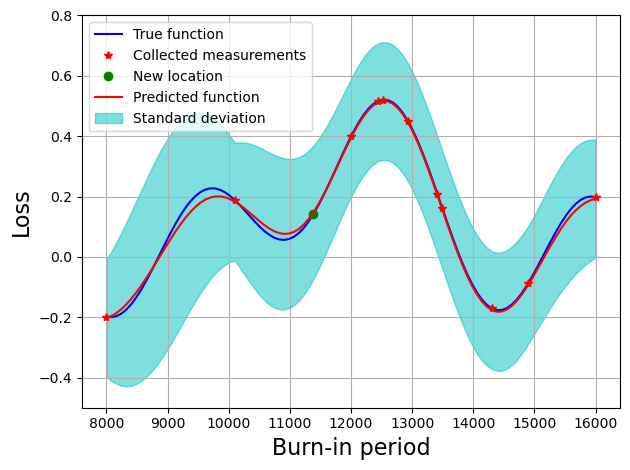

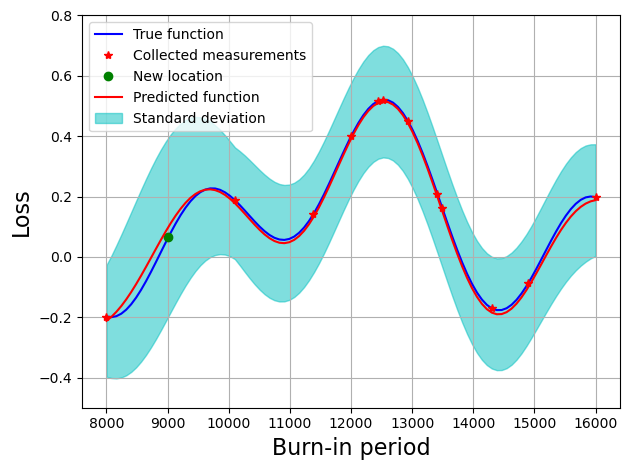

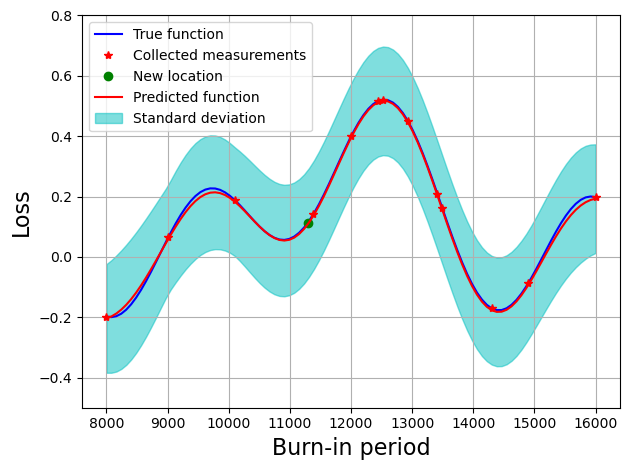

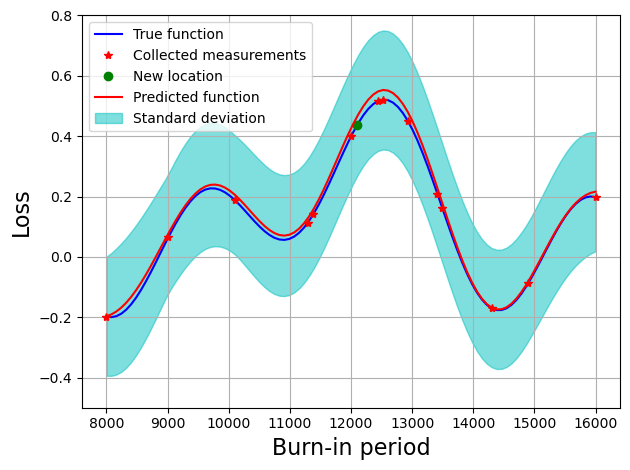

In [54]:
   
number_of_iterations = 15

# Dictionary:
# Key: parameter name
# Entry: tupple with (i) a list for the search space interval (start_val, end_val, num_points) and (ii) type of parameter
search_space = {'burnin_period':([8000, 16000, 100],int)}
maximize=True
list_of_parameters_names = ['burnin_period']


generate_images_flag = True
path_to_images = 'figures_1D/'
generate_gif_flag = True

bayes_optimizer = BO(search_space, list_of_parameters_names, maximize)


for ii in range(0, number_of_iterations):
    print("Iteration: ", ii)
    
    # Fit and get the next point to sample from Surrogate function
    next_parameter_values, loss_predicted, sigma, expected_improvement = bayes_optimizer.bayes_opt()
    
    # Generate the loss from the true loss function
    res = one_dim_function_complex(next_parameter_values['burnin_period'])
    print("The loss is:%f"%res)
    
    #update the 
    bayes_optimizer.update_loss(res)
    
    data_trace = pd.DataFrame.from_dict(bayes_optimizer.parameters_and_loss_dict,orient='index').transpose()  
    if generate_images_flag:
        generate_images_1D(path_to_images,data_trace,loss_predicted,sigma,search_space,ii)
    
if generate_gif_flag:
    generate_gif(path_to_images,number_of_iterations)

    
print(data_trace)

In [59]:
import matplotlib.image as mpimg # mpimg 用于读取图片
#from PIL import Image
#image =Image.open('./figures_1D/movie.gif') 
from PIL import Image

with Image.open("./figures_1D/movie.gif") as im:
    im.seek(1)  # skip to the second frame

    try:
        while 1:
            im.seek(im.tell() + 1)
            # do something to im
    except EOFError:
        pass  # end of sequence

In [19]:
bayes_optimizer.kernel

RBF(length_scale=5) * 1**2 + WhiteKernel(noise_level=0.2)

In [44]:
bayes_optimizer.list_of_parameters_names

['burnin_period']

In [28]:
bayes_optimizer.dict_of_means

{'burnin_period': [12000.0, 4000.0]}

In [27]:
bayes_optimizer.parameters_and_loss_dict 

{'burnin_period': [15190,
  8000,
  15515,
  16000,
  11555,
  12202,
  12606,
  8516,
  8829,
  12525,
  10020,
  8702,
  8469,
  9455,
  14869],
 'loss': [0.02179419405092415,
  -0.19773781909891147,
  0.13668888602482362,
  0.19800547955044123,
  0.20592019518048077,
  0.4695054186287629,
  0.519285208323812,
  -0.12558306998179783,
  -0.009141335499586956,
  0.5210679094111514,
  0.20219481407172796,
  -0.059813618164422676,
  -0.13970467851039908,
  0.2015570130950498,
  -0.09720598043113905]}

In [20]:
bayes_optimizer.meshgrid_linspacer_stack

array([[-1.        , -1.        ],
       [-1.        , -0.97979798],
       [-1.        , -0.95959596],
       ...,
       [ 1.        ,  0.95959596],
       [ 1.        ,  0.97979798],
       [ 1.        ,  1.        ]])

# 2D Example

1D case is not very practical as there usually many more hyper-parameters to be optimized. In this example we consider a 2D case with two hyper-parameters: burn-in period and learning rate. Visualising sampled points in 3D might be dificult. Below I also show the contour plot for the data — view from the top.

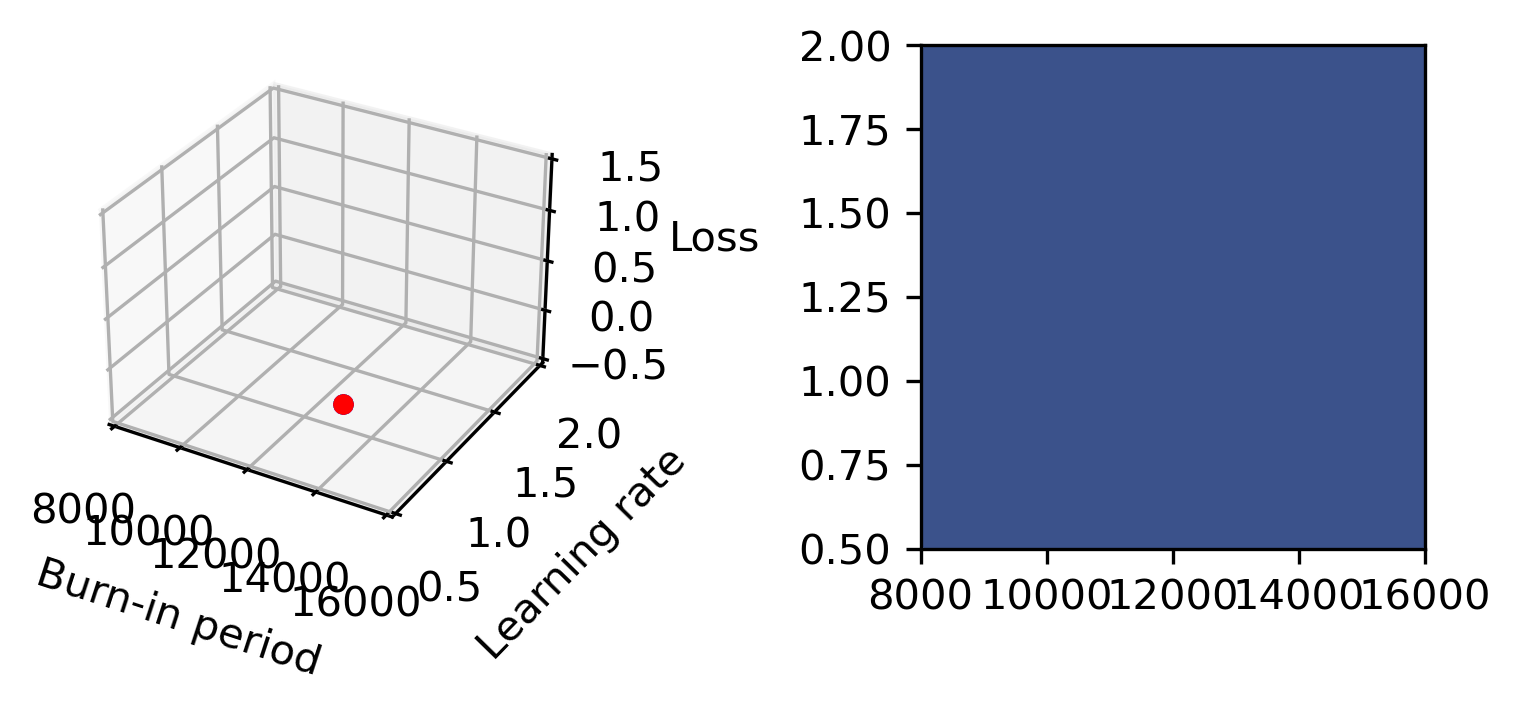

Iteration:  0
Iteration:  1


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 8000.0, 'learning_rate': 2.0}:
Iteration:  2
Next try paramters is {'burnin_period': 13656.565656565657, 'learning_rate': 0.7575757575757576}:
Iteration:  3
Next try paramters is {'burnin_period': 13494.949494949495, 'learning_rate': 0.7272727272727273}:
Iteration:  4


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 13010.10101010101, 'learning_rate': 0.6515151515151515}:
Iteration:  5


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 12282.828282828283, 'learning_rate': 0.5}:
Iteration:  6


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Next try paramters is {'burnin_period': 11878.787878787878, 'learning_rate': 0.696969696969697}:
Iteration:  7
Next try paramters is {'burnin_period': 12848.484848484848, 'learning_rate': 0.5}:
Iteration:  8
Next try paramters is {'burnin_period': 12525.252525252525, 'learning_rate': 0.5757575757575758}:
Iteration:  9
Next try paramters is {'burnin_period': 16000.0, 'learning_rate': 2.0}:
Iteration:  10
Next try paramters is {'burnin_period': 12444.444444444445, 'learning_rate': 1.696969696969697}:
Iteration:  11
Next try paramters is {'burnin_period': 12363.636363636364, 'learning_rate': 1.9242424242424243}:
Iteration:  12
Next try paramters is {'burnin_period': 11393.939393939394, 'learning_rate': 1.7727272727272727}:
Iteration:  13
Next try paramters is {'burnin_period': 13252.52525252525, 'learning_rate': 1.803030303030303}:
Iteration:  14
Next try paramters is {'burnin_period': 12606.060606060606, 'learning_rate': 1.4848484848484849}:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


    burnin_period  learning_rate      loss
0         13807.0        0.78643 -0.013047
1          8000.0        2.00000 -0.197738
2         13656.0        0.75758  0.067339
3         13494.0        0.72727  0.161284
4         13010.0        0.65152  0.419710
5         12282.0        0.50000  0.490305
6         11878.0        0.69697  0.347667
7         12848.0        0.50000  0.476892
8         12525.0        0.57576  0.521068
9         16000.0        2.00000  0.198005
10        12444.0        1.69697  0.516657
11        12363.0        1.92424  0.506282
12        11393.0        1.77273  0.144416
13        13252.0        1.80303  0.301245
14        12606.0        1.48485  0.519285


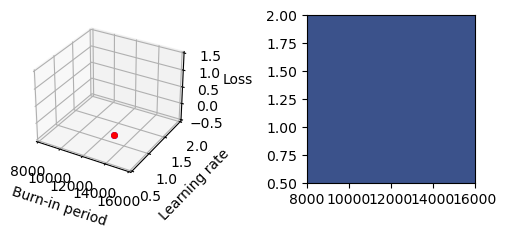

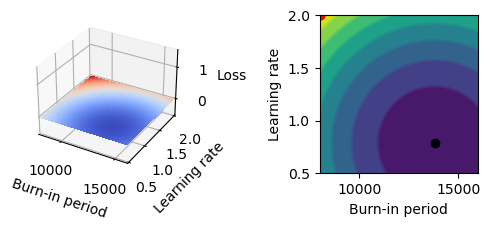

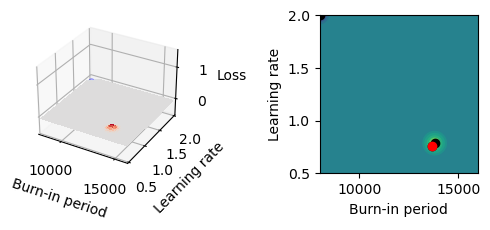

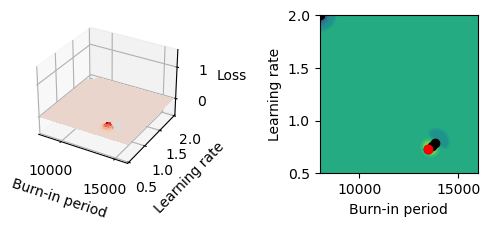

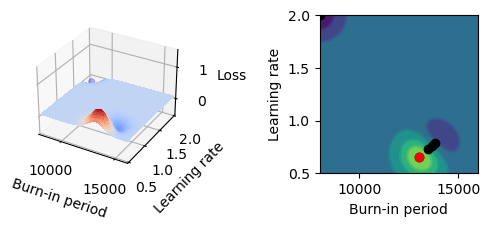

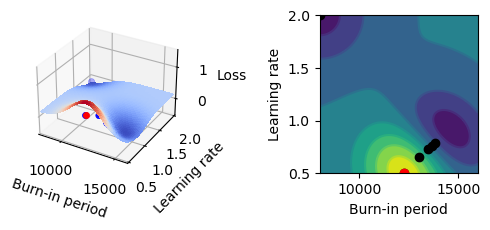

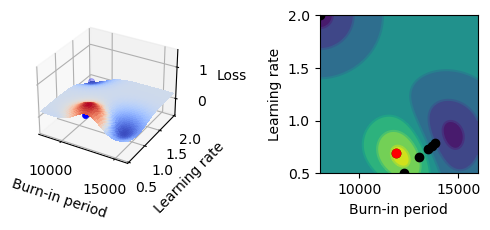

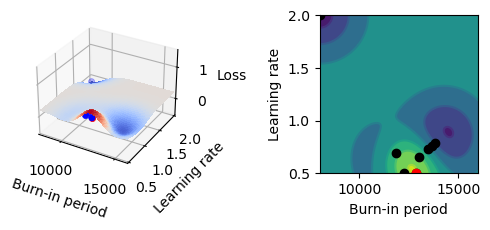

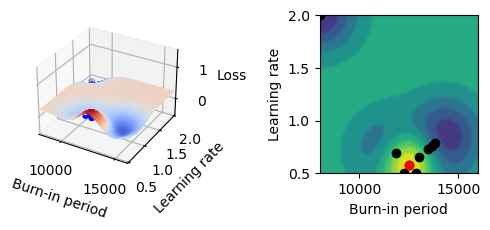

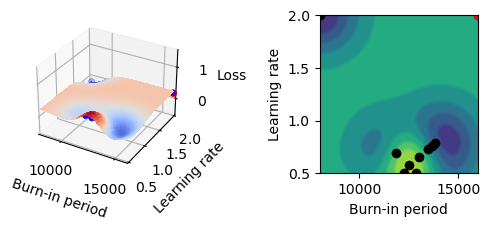

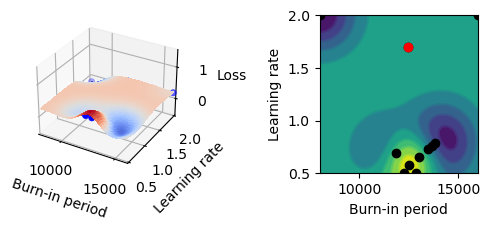

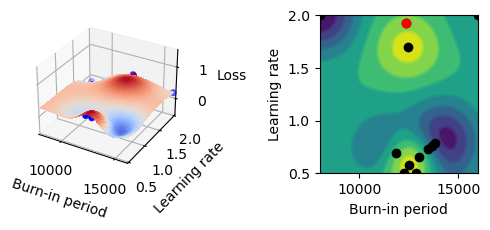

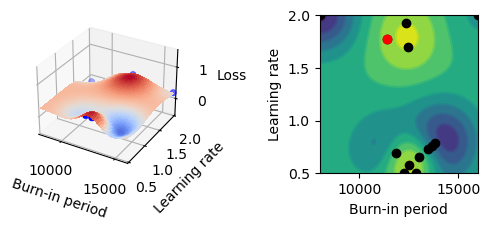

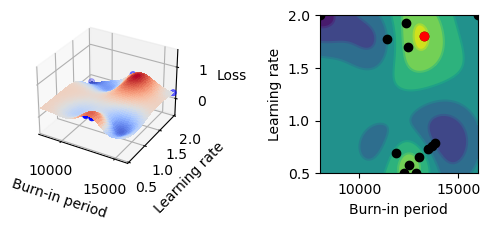

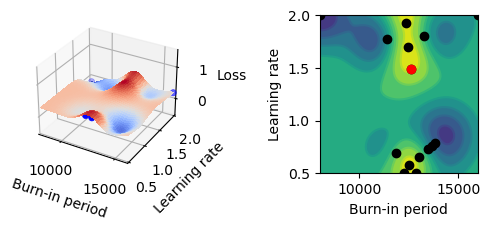

In [60]:

number_of_iterations = 15


# Dictionary:
# Key: parameter name
# Entry: tupple with (i) a list for the search space interval (start_val, end_val, num_points) and (ii) type of parameter
search_space = {'burnin_period':([8000, 16000, 100],int),
                'learning_rate':([0.5, 2.0, 100],float)}
maximize=True
list_of_parameters_names = ['burnin_period','learning_rate']



generate_images_flag = True
path_to_images = 'figures_2D/'
generate_gif_flag = True

bayes_optimizer = BO(search_space, list_of_parameters_names, maximize)


for ii in range(0, number_of_iterations):
    print("Iteration: ", ii)
    
    # Fit and get the next point to sample at
    next_parameter_values, loss_predicted, sigma, expected_improvement = bayes_optimizer.bayes_opt()
    
    # Generate the predition from the true function
    res = one_dim_function_complex(next_parameter_values['burnin_period'])
    
    
    bayes_optimizer.update_loss(res)
    
    data_trace = pd.DataFrame.from_dict(bayes_optimizer.parameters_and_loss_dict,orient='index').transpose()
    
    if generate_images_flag:
          
        generate_images_2D(path_to_images,data_trace,loss_predicted,sigma,search_space,ii)
    
if generate_gif_flag:
    generate_gif(path_to_images,number_of_iterations)

print(data_trace)
